In [1]:
import pysal
import pandas as pd
import numpy as np
import libpysal as ps
import geopandas as gp
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Gaussian, Binomial
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Saturday Dinner.csv')

In [3]:
df.head()

,shapeId,shapeType,shapeLabel,pointX,pointY,positive,days_to_positive,days_to_symptoms,days_since_last_vax,last_vax_date,Fri General Bkft,Fri Ldrshp Bkft,Fri Sem,Fri Lun,Fri Din,Sat Pic
0,7,point,2,394,877,1,4.0,4.0,64.0,4/1/22,NaN,Y,Y,Y,N,N
1,31,point,3,1485,415,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,point,4,122,272,1,4.0,2.0,24.0,5/11/22,N,NaN,N,N,N,N
3,13,point,5,396,206,1,3.0,3.0,66.0,3/30/22,Y,NaN,Y,Y,Y,N
4,30,point,6,1599,900,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
coords = df[['pointX', 'pointY']]

In [5]:
y = df['positive']
X = df[['days_since_last_vax', 'Fri General Bkft', 'Fri Ldrshp Bkft', 'Fri Sem', 'Fri Lun', 'Fri Din', 'Sat Pic']]

In [ ]:
# fill missing values with average or "N" for no attendance...
X['days_since_last_vax'] = X['days_since_last_vax'].fillna(X['days_since_last_vax'].mean())
X[['Fri General Bkft', 'Fri Ldrshp Bkft', 'Fri Sem', 'Fri Lun', 'Fri Din', 'Sat Pic']] = X[['Fri General Bkft', 'Fri Ldrshp Bkft', 'Fri Sem', 'Fri Lun', 'Fri Din', 'Sat Pic']].fillna('N').eq('Y').mul(1)

In [7]:
X

,days_since_last_vax,Fri General Bkft,Fri Ldrshp Bkft,Fri Sem,Fri Lun,Fri Din,Sat Pic
0,64.0,0,1,1,1,0,0
1,48.0,0,0,0,0,0,0
2,24.0,0,0,0,0,0,0
3,66.0,1,0,1,1,1,0
4,48.0,0,0,0,0,0,0
5,48.0,0,0,0,0,0,0
6,57.0,0,0,1,1,1,0
7,48.0,0,0,0,0,0,0
8,48.0,0,0,0,0,0,0
9,48.0,0,0,0,0,0,0


In [8]:
# Logistic Regression Model (NO SPATIAL COORDINATES)
model = LogisticRegression(solver='liblinear', random_state=42).fit(X, y)

In [9]:
model.score(X, y)

0.9148936170212766

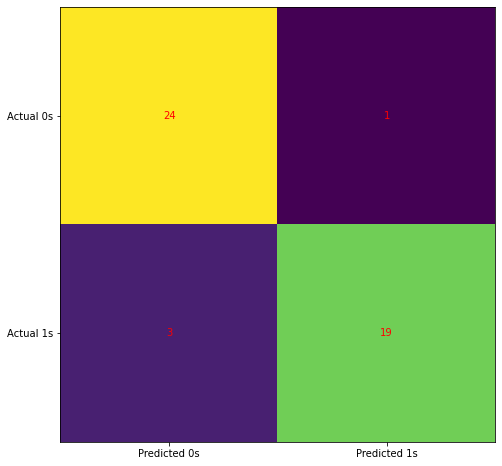

In [10]:
cm = confusion_matrix(y, model.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

This logistic model was able to fit the data with high accuracy... unfortunately there's a lack of attendance information for attendees who did not report testing positive. I made the (probably inaccurate) assumption that they did not attend previous sessions and that their days-since-last-vaccine was the average. This missing-data imputation is probably the cause for such a highly accurate model.

In [11]:
# Geographically Weighted Regression

In [12]:
coords_list = list(zip(coords['pointX'], coords['pointY']))

In [13]:
y_reshape = np.array(y).reshape((-1,1))
X_reshape = np.array(X)

In [14]:
model_gwr = GWR(coords_list, y_reshape, X_reshape, bw=40, family=Binomial())
results = model_gwr.fit()
print(results.params.shape)

(47, 8)


/Users/michelle.ho/.virtualenvs/covid19/lib/python3.8/site-packages/spglm/links.py:168: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [15]:
results.summary()

Model type                                                         Binomial
Number of observations:                                                  47
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                             0.000
Log-likelihood:                                                         nan
AIC:                                                                    nan
AICc:                                                                19.789
BIC:                                                               -150.156
Percent deviance explained:                                           1.000
Adj. percent deviance explained:                                      1.000

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

/Users/michelle.ho/.virtualenvs/covid19/lib/python3.8/site-packages/spglm/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  return scale * np.sum((endog * np.log(mu/(1 - mu) + 1e-200) +
/Users/michelle.ho/.virtualenvs/covid19/lib/python3.8/site-packages/spglm/family.py:891: RuntimeWarning: divide by zero encountered in log
  np.log(1 - mu)) * freq_weights)
/Users/michelle.ho/.virtualenvs/covid19/lib/python3.8/site-packages/spglm/family.py:890: RuntimeWarning: invalid value encountered in add
  return scale * np.sum((endog * np.log(mu/(1 - mu) + 1e-200) +
